<h1 style='text-align:center; font-weight:bold'>Imports</h1>

In [47]:
import os
import cv2
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Dropout, Conv2D, MaxPooling2D


<h1 style='text-align:center; font-weight:bold'>Load Data</h1>

In [21]:
def loadData(xData, yData, root, type):
    dataDir = f"{root} Images/{type}"
    
    for className in os.listdir(dataDir):
        classDir = os.path.join(dataDir, className)
        if not os.path.isdir(classDir):
            continue

        for imageFile in os.listdir(classDir):
            if not (imageFile.endswith(".jpg") or imageFile.endswith(".png")):
                continue

            imagePath = os.path.join(classDir, imageFile)
            image = cv2.imread(imagePath)

            if image is None:
                print(f"Warning: Unable to read image {imagePath}. Skipping...")
                continue

            image = cv2.resize(image, (96, 96))
            xData.append(image)
            yData.append(className)

    return xData, yData


In [22]:
print(f"\n\t\t\t\t     Loading Data:")
print(f"\n********************************************************************************************\n")
xTrain, yTrain = [], []
xTrain, yTrain = tqdm(loadData(xTrain, yTrain, 'Labeled',"train"), desc="Loading Training Data")
xTrain, yTrain = tqdm(loadData(xTrain, yTrain, 'Processed',"train"), desc="Loading Training Data")
print(f"Training: {len(xTrain)} images, {len(yTrain)} labels")

print(f"\n********************************************************************************************\n")

xVal, yVal = [], []
xVal, yVal = tqdm(loadData(xVal, yVal, 'Labeled', "valid"), desc="Loading Validation Data")
xVal, yVal = tqdm(loadData(xVal, yVal, 'Processed', "valid"), desc="Loading Validation Data")
print(f"Validation: {len(xVal)} images, {len(yVal)} labels")

print(f"\n********************************************************************************************\n")

xTest, yTest = [], []
xTest, yTest = tqdm(loadData(xTest, yTest, 'Labeled' ,"test"), desc="Loading Testing Data")
xTest, yTest = tqdm(loadData(xTest, yTest, 'Processed' ,"test"), desc="Loading Testing Data")
print(f"Testing: {len(xTest)} images, {len(yTest)} labels")



				     Loading Data:

********************************************************************************************



Loading Training Data: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training: 34202 images, 34202 labels

********************************************************************************************



Loading Validation Data: 100%|██████████| 2/2 [00:00<?, ?it/s]


Validation: 10812 images, 10812 labels

********************************************************************************************



Loading Testing Data: 100%|██████████| 2/2 [00:00<?, ?it/s]

Testing: 5510 images, 5510 labels


<h1 style='text-align:center; font-weight:bold'>Global Variables</h1>

In [23]:

INPUT_SHAPE = (96, 96, 3)
BATCH_SIZE = 150
EPOCHS = 20
CLASS_NAMES = [
    "Anger",
    "Contempt",
    "Disgust",
    "Fear",
    "Happy",
    "Neutral",
    "Sad",
    "Surprise",
]
COLOR_PALETTE_3 = [
    "#3d405b",
    "#e07a5f",
    "#f4f1de"
]
BACKGROUND_COLOR ="#fdfffc"
TITLE_COLOR = "#156064"
LABEL_COLOR = "#773344"
METRICS_COLOR = [
    "#e8b6ae",
    "#7e7771",
    "#2d4449",
    "#ded9b3"
]
COLOR_PALETTE_2 = [
    "#f5deb3",
    "#3d4b5a"
]
encoder = LabelEncoder()

<h1 style='text-align:center; font-weight:bold'>Data Visualization</h1>

In [24]:
def countClassLabels(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

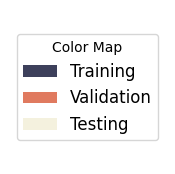

In [45]:
def plotLegend():
    plt.figure(figsize=(2, 2))
    bars = plt.bar([0, 1, 2], [0, 0, 0], color=COLOR_PALETTE_3[:3], label=['Training', 'Validation', 'Testing'])
    plt.axis('off')
    plt.legend(bars, ['Training', 'Validation', 'Testing'], loc='center', fontsize=12, title="Color Map")
    plt.show()
plotLegend()

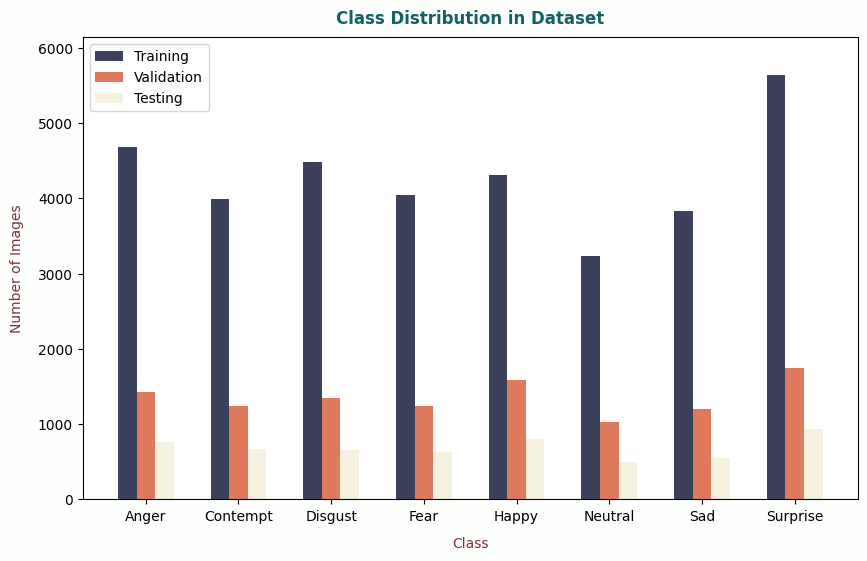

In [26]:
def plotDistribution(yTrain, yVal, yTest):
    
    trainClassCounts = countClassLabels(yTrain)
    valClassCounts = countClassLabels(yVal)
    testClassCounts = countClassLabels(yTest)

    trainCounts = [trainClassCounts[className] for className in CLASS_NAMES]
    valCounts = [valClassCounts[className] for className in CLASS_NAMES]
    testCounts = [testClassCounts[className] for className in CLASS_NAMES]

    x = np.arange(len(CLASS_NAMES)) 
    width = 0.2  

    plt.figure(figsize=(10, 6))
    maxCount = max(max(trainCounts), max(valCounts), max(testCounts))
    plt.ylim(0, maxCount + 500)
    
    plt.bar(x - width, trainCounts, width, label='Class', color=COLOR_PALETTE_3[0])
    plt.bar(x, valCounts, width, label='Class', color=COLOR_PALETTE_3[1])
    plt.bar(x + width, testCounts, width, label='Class', color=COLOR_PALETTE_3[2])
    
    plt.gcf().set_facecolor(BACKGROUND_COLOR) 
    plt.gca().set_facecolor('#ffffff')
    
    plt.xlabel('Class', labelpad=10, color=LABEL_COLOR)
    plt.ylabel('Number of Images', labelpad=10, color=LABEL_COLOR)
    plt.title('Class Distribution in Dataset', fontweight='bold', fontsize=12, pad=10, color=TITLE_COLOR)
    plt.xticks(x, CLASS_NAMES, rotation=0)
    plt.legend(['Training', 'Validation', 'Testing'])
    plt.show()

plotDistribution(yTrain, yVal, yTest)


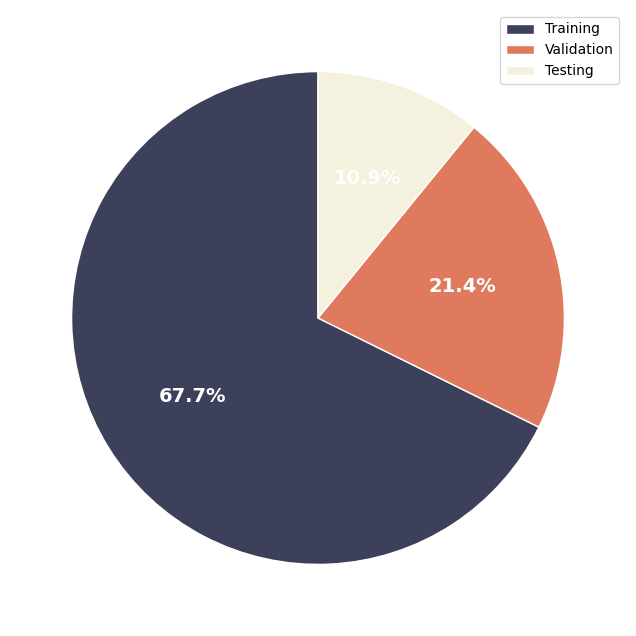

In [27]:
def plotPieChart(yTrain, yVal, yTest):
    total = len(yTrain) + len(yVal) + len(yTest)
    sizes = [len(yTrain) / total * 100, len(yVal) / total * 100, len(yTest) / total * 100]
    
    labels = ['Training', 'Validation', 'Testing']
    
    plt.figure(figsize=(8, 8))
    
    plt.gca().set_facecolor('#ffffff')
    
    wedges, texts, autotexts = plt.pie(sizes, colors=COLOR_PALETTE_3, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': '#FFFFFF'}, textprops={'color': BACKGROUND_COLOR})

    for autotext in autotexts:
        autotext.set_fontsize(14)  
        autotext.set_fontweight('bold') 

    for text in texts:
        text.set_fontsize(12) 
        text.set_fontweight('bold') 
        text.set_color(LABEL_COLOR)  
        
    plt.legend(['Training', 'Validation', 'Testing'])
    plt.show()

plotPieChart(yTrain, yVal, yTest)


<h1 style='text-align:center; font-weight:bold'>Model Building</h1>

In [28]:
def buildModel():
    model = Sequential()
    net = ResNet152(weights='imagenet', include_top=False,
        input_shape=INPUT_SHAPE, pooling='max')

    for layer in net.layers:
        layer.trainable=True
        
    model.add(net)
    # model.add(Flatten())

    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(8, activation='relu'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h1 style='text-align:center; font-weight:bold'>Performance Metrics</h1>

In [29]:
def plotConfusionMatrix(confusionMatrix):
    COLOR_MAP = ListedColormap(COLOR_PALETTE_3)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap=COLOR_MAP, cbar=False,
                annot_kws={"size": 10}, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=10, color=TITLE_COLOR)
    plt.xlabel('Predicted label', fontsize=12, color=LABEL_COLOR)
    plt.ylabel('True label', fontsize=12, color=LABEL_COLOR)
    
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=90)
    
    plt.show()


In [30]:
def plotMetrics(metrics):
    metricNames = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    metricValues = [metrics['accuracy'], metrics['recall'], metrics['precision'], metrics['f1']]

    plt.figure(figsize=(8, 5))
    
    for i in range(len(metricNames)):
        plt.barh(metricNames[i], metricValues[i], color=METRICS_COLOR[i])
    
    plt.gcf().set_facecolor(BACKGROUND_COLOR) 
    plt.gca().set_facecolor('#ffffff')
    
    plt.title('Performance Metrics', fontsize=14, fontweight='bold', pad=10, color=TITLE_COLOR)
    plt.xlim(0, 1)
    
    plt.show()


In [31]:
def printMetrics(model, yTest, predictions):
    metrics = {
        'accuracy': accuracy_score(yTest, predictions),
        'recall': recall_score(yTest, predictions, average='weighted'),
        'precision': precision_score(yTest, predictions, average='weighted'),
        'f1': f1_score(yTest, predictions, average='weighted'),
        'confusionMatrix': confusion_matrix(yTest, predictions),
    }
    print(f"\nMetrics for {model}:")
    print(f'Accuracy: {metrics["accuracy"]:.4f}')
    print(f'Recall (Sensitivity): {metrics["recall"]:.4f}')
    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'F1: {metrics["f1"]:.4f}')
    print(f'Confusion Matrix: \n{metrics["confusionMatrix"]}')
    plotMetrics(metrics)
    plotConfusionMatrix(metrics['confusionMatrix'])

In [37]:
def plotTrainingHistory(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    fig.patch.set_facecolor(BACKGROUND_COLOR)
    axes[0].set_facecolor('#ffffff')
    axes[1].set_facecolor('#ffffff')

    axes[0].plot(history['loss'], label='Training Loss', color=COLOR_PALETTE_2[0])
    axes[0].plot(history['val_loss'], label='Validation Loss', color=COLOR_PALETTE_2[1])
    axes[0].set_xlabel('Epochs', fontsize=12, color=LABEL_COLOR)
    axes[0].set_ylabel('Loss', fontsize=12, color=LABEL_COLOR)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=10, color=TITLE_COLOR)
    axes[0].legend()

    axes[1].plot(history['accuracy'], label='Training Accuracy', color=COLOR_PALETTE_2[0])
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color=COLOR_PALETTE_2[1])
    axes[1].set_xlabel('Epochs', fontsize=12, color=LABEL_COLOR)
    axes[1].set_ylabel('Accuracy', fontsize=12, color=LABEL_COLOR)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=10, color=TITLE_COLOR)
    axes[1].legend()

    plt.subplots_adjust(wspace=0.3)  
    plt.show()

<h1 style='text-align:center; font-weight:bold'>Preparing To Run</h1>

In [33]:
model = buildModel() 
model.name = 'Facial_Emotion_Classifier'
model.summary()

Model: "Facial_Emotion_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 2048)           │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,897,544 (224.68 MB)

 Trainable params: 58,746,120 (224.10 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [34]:
xTrain = np.array(xTrain)
xVal = np.array(xVal)
xTest = np.array(xTest)

yTrain = to_categorical(encoder.fit_transform(yTrain), num_classes=len(CLASS_NAMES))
yVal = to_categorical(encoder.transform(yVal), num_classes=len(CLASS_NAMES))
yTest = to_categorical(encoder.transform(yTest), num_classes=len(CLASS_NAMES))

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    verbose=1,           
    restore_best_weights=True  
)

<h1 style='text-align:center; font-weight:bold'>Run Time</h1>

In [36]:
try:
    history = model.fit(
        xTrain, 
        yTrain, 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        validation_data=(xVal, yVal),
        callbacks=[early_stopping]
    )
except Exception as e:
    print(f"Error occurred during training: {e}")

Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 4634s 20s/step - accuracy: 0.2727 - loss: 2.0244 - val_accuracy: 0.1463 - val_loss: 3.5499
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 4171s 18s/step - accuracy: 0.3189 - loss: 1.8102 - val_accuracy: 0.2988 - val_loss: 2.1250
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 3642s 16s/step - accuracy: 0.3254 - loss: 1.8326 - val_accuracy: 0.3762 - val_loss: 1.7406
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2698s 12s/step - accuracy: 0.4020 - loss: 1.5922 - val_accuracy: 0.4234 - val_loss: 1.6626
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2562s 11s/step - accuracy: 0.4381 - loss: 1.5108 - val_accuracy: 0.2218 - val_loss: 4.3688
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2564s 11s/step - accuracy: 0.2725 - loss: 1.9375 - val_accuracy: 0.3222 - val_loss: 2.2783
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2564s 11s/step - accuracy: 0.3639 - loss: 1.7098 - val_accuracy: 0.3538 - val_loss: 1.9850
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2619s 11s/step - accuracy: 0.3458 - loss: 1

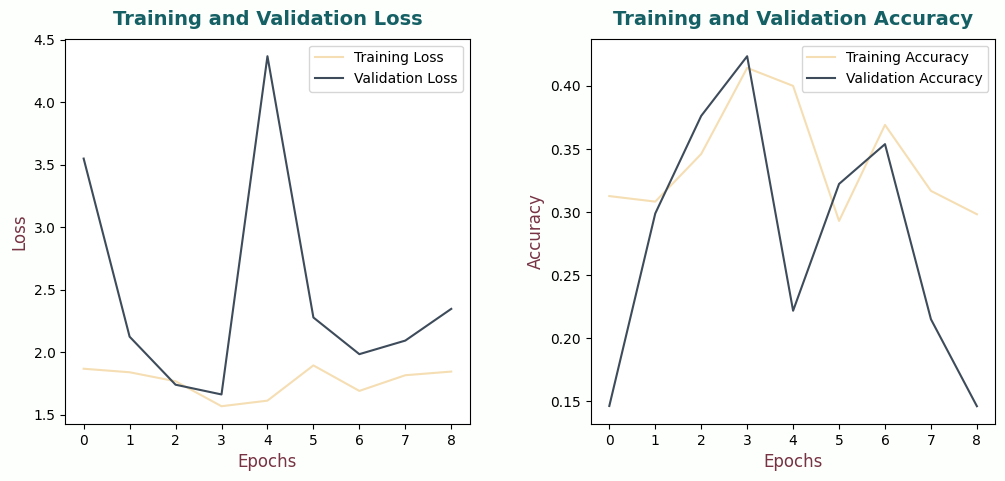

173/173 ━━━━━━━━━━━━━━━━━━━━ 127s 734ms/step

Metrics for <Sequential name=Facial_Emotion_Classifier, built=True>:
Accuracy: 0.4174
Recall (Sensitivity): 0.4174
Precision: 0.5153
F1: 0.4481
Confusion Matrix: 
[[358  37 189  49   4  21  91  27]
 [ 49 340 104  18 181  56  71  70]
 [ 94  61 114  31  17  22  93  31]
 [  5   0   0   1   0   0   1   0]
 [  3  43  21   3 536   2   7  14]
 [113 107  89  20  39 273  85 154]
 [ 61   8  51  37   7  30  79  41]
 [ 83  68  86 477  14  96 129 599]]


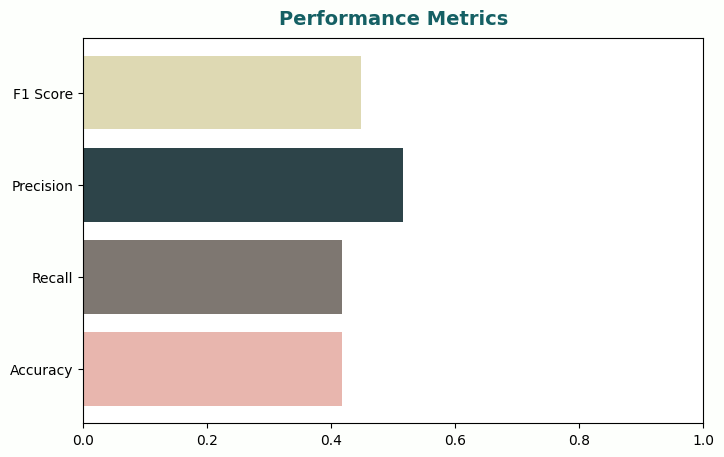

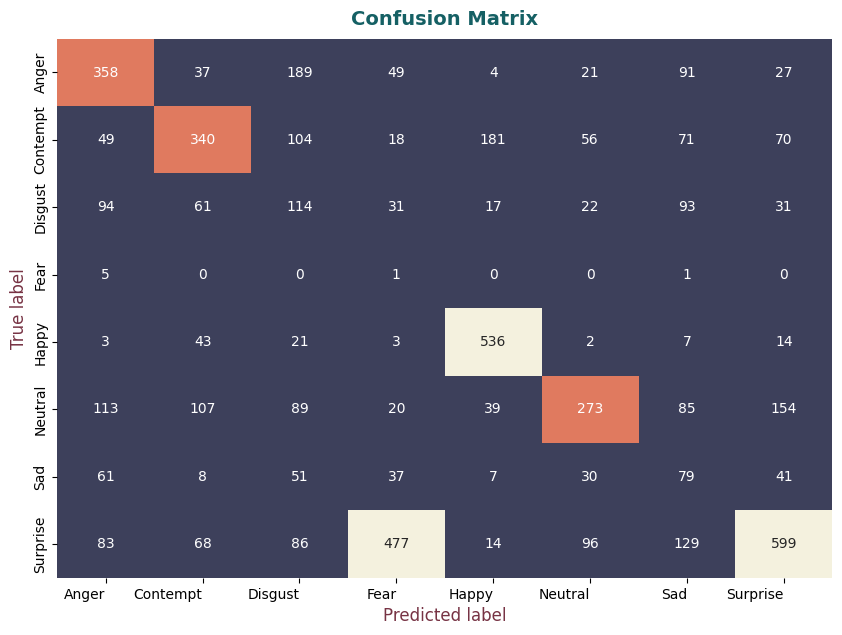

In [41]:
plotTrainingHistory(history.history)
predictions = model.predict(xTest)
predictions = np.argmax(predictions, axis=1)
yTest = np.argmax(yTest, axis=1)
printMetrics(model, predictions, yTest)

In [44]:
model.save(f"{model.name}.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


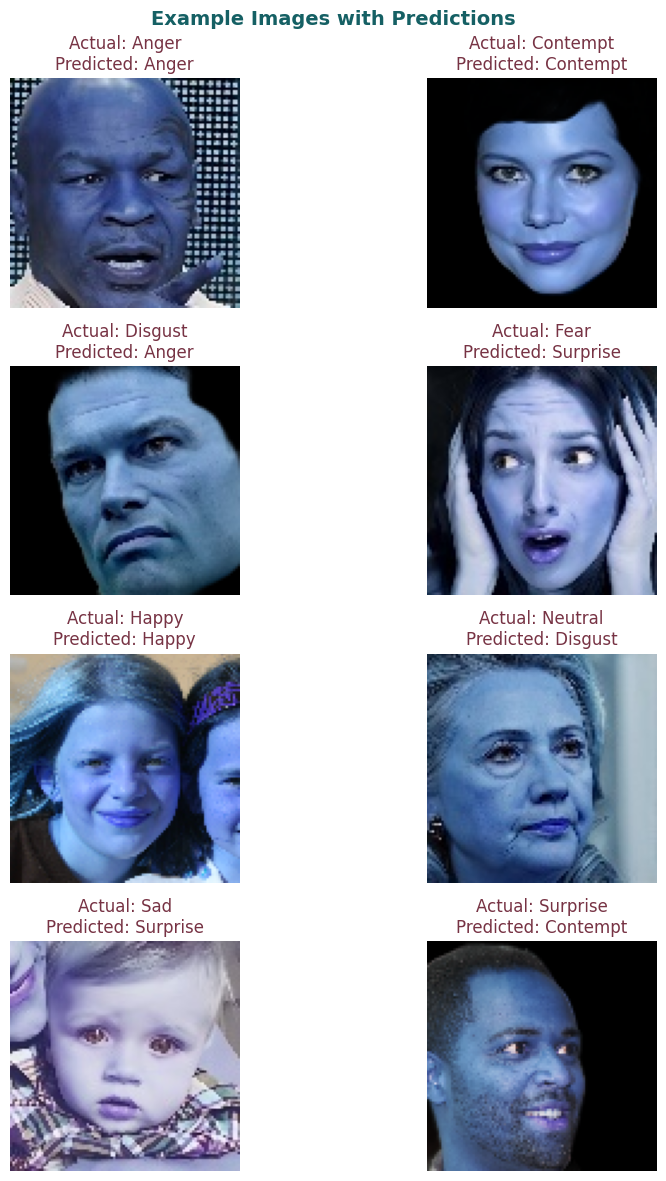

In [57]:
def plotExampleImages(model, xTrain, yTrain):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    for index in range(len(CLASS_NAMES)):
        classIndices = np.where(np.argmax(yTrain, axis=1) == index)[0] 
        i = random.choice(classIndices)
        image = xTrain[i]
        actual = yTrain[i] 
        actual = np.argmax(actual)
        prediction = model.predict(np.expand_dims(image, axis=0))
        prediction = np.argmax(prediction, axis=1)
        ax = axes[index // 2, index % 2]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Actual: {CLASS_NAMES[actual]}\nPredicted: {CLASS_NAMES[prediction[0]]}', fontsize=12, color=LABEL_COLOR)
    
    plt.suptitle('Example Images with Predictions', fontsize=14, fontweight='bold', color=TITLE_COLOR)
    plt.tight_layout()
    plt.show()

plotExampleImages(model, xTrain, yTrain)